# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

---
## Step 0: Load The Data

In [150]:
# Imports

import pickle
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.contrib.layers import flatten
from os import listdir
import cv2
import csv
import collections
from collections import Counter
import pandas as pd
from PIL import ImageEnhance
from skimage import io
from scipy import ndimage
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
K.set_image_dim_ordering('tf')

In [151]:
# Load pickled data

path = "/Users/avnitmackin/Development/SelfDrivingCarCourse/CarND-Traffic-Sign-Classifier-Project/traffic-signs-data/"
training_file = "train.p"
validation_file="valid.p"
testing_file = "test.p"

with open(path+training_file, mode='rb') as f:
    train = pickle.load(f)
with open(path+validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(path+testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

coords_train = train['coords']
coords_test = test['coords']
coords_valid = valid['coords']

sizes_train = train['sizes']
sizes_test = test['sizes']
sizes_valid = valid['sizes']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

### A Basic Summary of the Data Set Using Python, Numpy and Pandas

In [152]:
n_train = len(X_train)
n_train_y = len(y_train)
n_test = len(X_test)
image_shape = X_train[0].shape
counter_train = Counter(y_train)
counter_test = Counter(y_test)
counter_valid = Counter(y_valid)

n_classes = len(counter_train.keys())

print("Number of training examples =", n_train)
print("Number of labels in training examples =", n_train_y)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of labels in training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

In [153]:
# Read sign names from csv file

csv_file = '/Users/avnitmackin/Development/SelfDrivingCarCourse/CarND-Traffic-Sign-Classifier-Project/signnames.csv'
df = pd.read_csv(csv_file)
sign_names = df.SignName
print(sign_names)

0                                  Speed limit (20km/h)
1                                  Speed limit (30km/h)
2                                  Speed limit (50km/h)
3                                  Speed limit (60km/h)
4                                  Speed limit (70km/h)
5                                  Speed limit (80km/h)
6                           End of speed limit (80km/h)
7                                 Speed limit (100km/h)
8                                 Speed limit (120km/h)
9                                            No passing
10         No passing for vehicles over 3.5 metric tons
11                Right-of-way at the next intersection
12                                        Priority road
13                                                Yield
14                                                 Stop
15                                          No vehicles
16             Vehicles over 3.5 metric tons prohibited
17                                             N

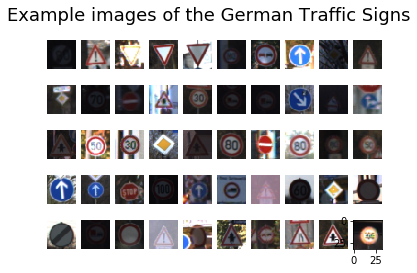

In [154]:
### Data exploration visualization

%matplotlib inline

X_train, y_train = shuffle(X_train, y_train)

fig = plt.figure()
fig.suptitle('Example images of the German Traffic Signs', fontsize=18)

for i in range(50):
    image = X_train[i].squeeze()
    plt.axis("off")
    plt.subplot(5,10,i+1)
    plt.imshow(image)
    

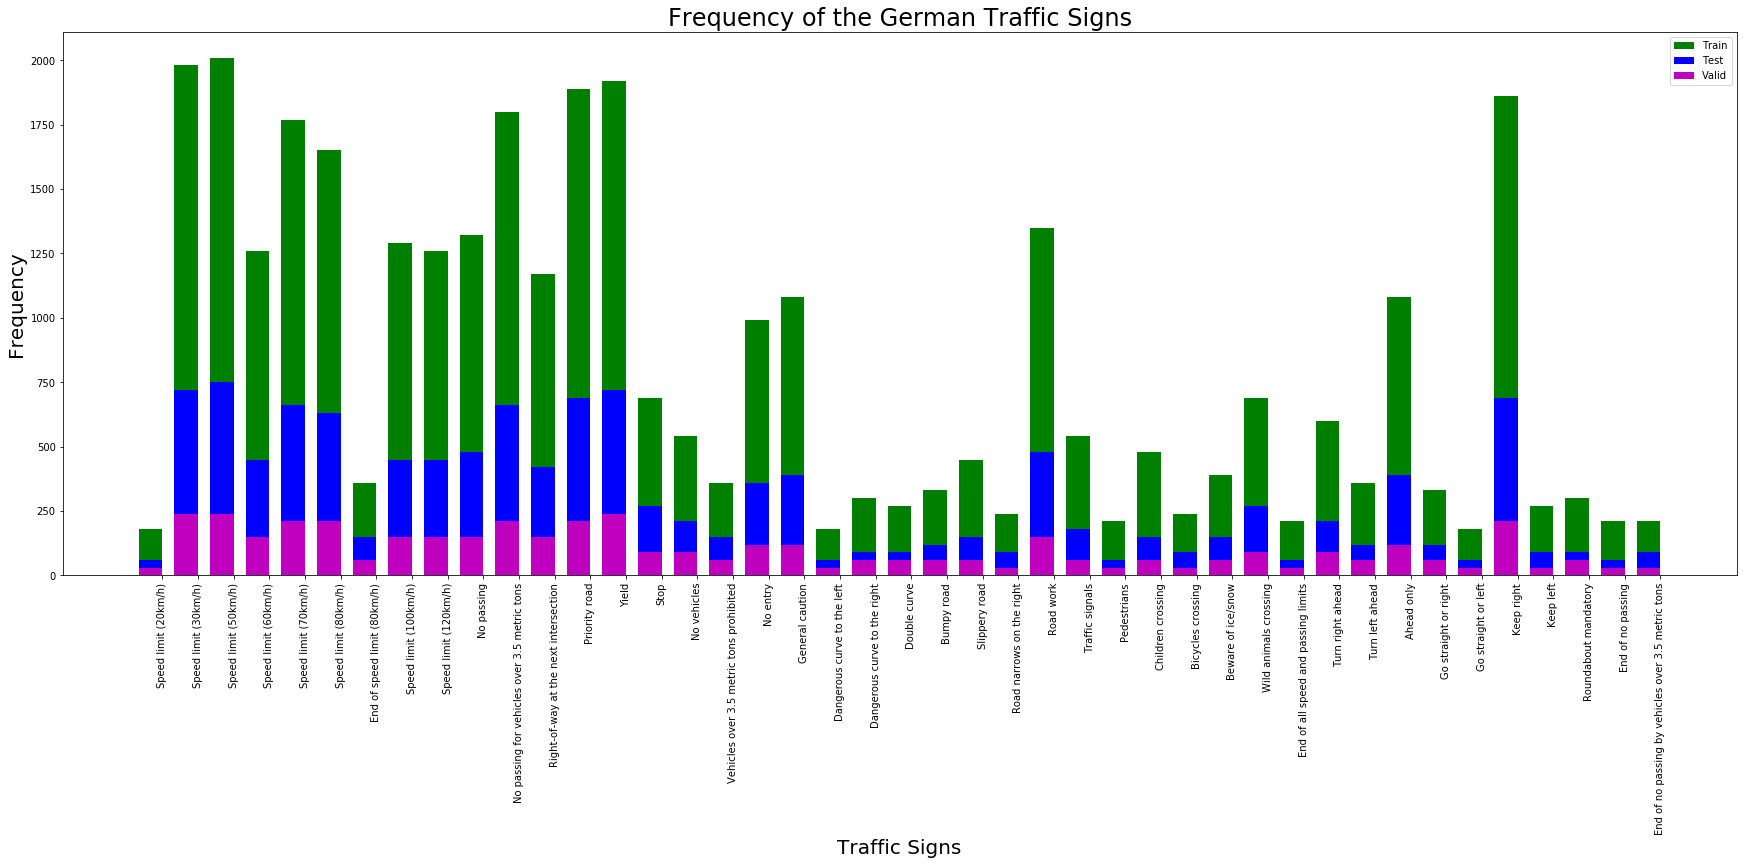

In [155]:
# Bar chart

# The data of the chart
y_train_plot = counter_train.values()
x_plot = list(counter_train.keys())
y_test_plot = counter_test.values()
y_vaild_plot = counter_valid.values()

ind = np.arange(len(x_plot))
# Constants of the chart

width = 1/1.5

# Strech of the chart

fig = plt.figure(figsize=(30,10))
ax = fig.add_subplot(111)

# The bars of the chart
chart_train = ax.bar(ind, y_train_plot, width, color="g")
chart_test = ax.bar(ind, y_test_plot, width, color="b")
chart_valid = ax.bar(ind, y_vaild_plot, width, color="m")

# add some text for labels, title and axes ticks
ax.set_ylabel('Frequency', fontsize=20)
ax.set_xlabel('Traffic Signs', fontsize=20)
ax.set_title('Frequency of the German Traffic Signs', fontsize=24)
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(sign_names, rotation=90)

ax.legend((chart_train[0], chart_test[0],chart_valid[0] ), ('Train', 'Test','Valid'))

plt.show()




(-0.5, 31.5, 31.5, -0.5)

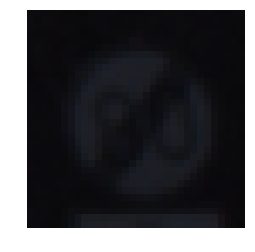

In [156]:
# Show one image from the dataset before preprosess:

plt.imshow(X_train[0])
plt.axis("off")

----

## Step 2: Design and Test a Model Architecture

### Pre-process the Data Set (normalization, grayscale, etc.)

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [157]:
def normalize_grayscale(image_data):
    """
    Normalize the image data with Min-Max scaling to a range of [0.1, 0.9]
    :param image_data: The image data to be normalized
    :return: Normalized image data
    """
    a = 0.1
    b = 0.9
    grayscale_min = 0
    grayscale_max = 255
    return a + ( ( (image_data - grayscale_min)*(b - a) )/( grayscale_max - grayscale_min ) )

In [158]:
## from : http://www.pyimagesearch.com/2015/10/05/opencv-gamma-correction/
## Adding light to dark images

def adjust_gamma(image, gamma=1.0):

    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
    for i in np.arange(0, 256)]).astype("uint8")
 
    # apply gamma correction using the lookup table
    return cv2.LUT(image, table)

In [159]:
def preprocess_images(input):
    len_input = len(input)
    temp =[]
    for i in range(len_input):
        image = adjust_gamma(input[i], 3)
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        image = cv2.equalizeHist(image)
        image = normalize_grayscale(image)
        image = image[:, :, np.newaxis]
        temp.append(image)
    return temp

In [160]:
### Preprocess the data

X_train = preprocess_images(X_train)
X_test = preprocess_images(X_test)
X_valid = preprocess_images(X_valid)

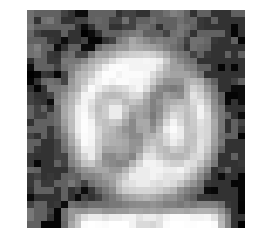

In [161]:
# Show one image from the dataset after preprosess:

image = X_train[0].squeeze()
plt.axis("off")
plt.imshow(image, cmap='gray')

In [162]:
def shift_aug_imgs(imgs,shift_f):
    shift = shift_f
    shift_gen = ImageDataGenerator(width_shift_range=shift, height_shift_range=shift)
    shift_gen.fit(imgs)

In [163]:
def rot_aug_imgs(imgs,angle):
    rot_gen = ImageDataGenerator(rotation_range=angle)

In [164]:
def augment_imgs(imgs):
    rot_aug_imgs(imgs,30)
    shift_aug_imgs(imgs,0.2)

In [165]:
# Augment the data using rotations and shifting

augment_imgs(X_train)
augment_imgs(X_test)
augment_imgs(X_valid)

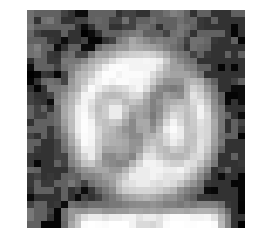

In [166]:
# Show one image from the dataset after augmentation:

image = X_train[0].squeeze()
plt.axis("off")
plt.imshow(image, cmap='gray')

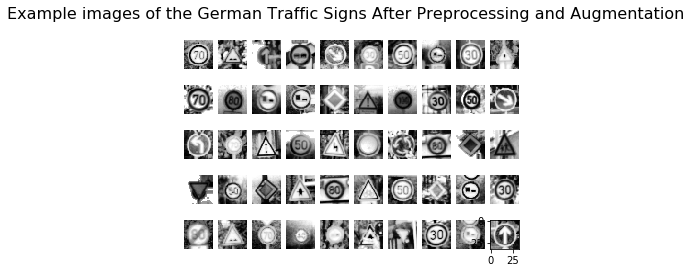

In [167]:
# Visualizations of the data after preprocessing it.

%matplotlib inline

X_train, y_train = shuffle(X_train, y_train)

fig = plt.figure()
fig.suptitle('Example images of the German Traffic Signs After Preprocessing and Augmentation', fontsize=16)

for i in range(50):
    image = X_train[i].squeeze()
    plt.axis("off")
    plt.subplot(5,10,i+1)
    plt.imshow(image, cmap='gray')
    

### Model Architecture

In [168]:
def MyNet(x):    
   
    mu = 0
    sigma = 0.1
    global conv2_dropout
    
    keep_prob = tf.constant(0.5,dtype=tf.float32)
    
    # Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5,1, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
        
    # Activation.
    conv1 = tf.nn.dropout(conv1,keep_prob)

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
        
    # Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2 = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
   
    # Activation.
    conv2_dropout = tf.nn.dropout(conv2,keep_prob)
    
    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2_max = tf.nn.max_pool(conv2_dropout, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten. Input = 5x5x16. Output = 400.
    fc0 = flatten(conv2_max)

    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b

    # Activation.
    fc1 = tf.nn.sigmoid(fc1)
    
    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b

    # Activation.
    fc2 = tf.nn.sigmoid(fc2)

    # Layer 5: Fully Connected. Input = 84. Output = n_classes.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, n_classes), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(n_classes))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

### Train, Validate and Test the Model

In [169]:
# Constants

x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)

In [170]:
# Model evaluation

rate = 0.001

logits = MyNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

In [171]:
# Model evaluation

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [172]:
# Train the model

EPOCHS = 100
BATCH_SIZE = 128

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        training_accuracy = evaluate(X_train, y_train)
        print("EPOCH {} ...".format(i+1))
        print("Training Accuracy = {:.3f}".format(training_accuracy))
        print()
        
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Training Accuracy = 0.463

EPOCH 1 ...
Validation Accuracy = 0.422

EPOCH 2 ...
Training Accuracy = 0.681

EPOCH 2 ...
Validation Accuracy = 0.651

EPOCH 3 ...
Training Accuracy = 0.776

EPOCH 3 ...
Validation Accuracy = 0.754

EPOCH 4 ...
Training Accuracy = 0.823

EPOCH 4 ...
Validation Accuracy = 0.793

EPOCH 5 ...
Training Accuracy = 0.854

EPOCH 5 ...
Validation Accuracy = 0.815

EPOCH 6 ...
Training Accuracy = 0.872

EPOCH 6 ...
Validation Accuracy = 0.832

EPOCH 7 ...
Training Accuracy = 0.889

EPOCH 7 ...
Validation Accuracy = 0.844

EPOCH 8 ...
Training Accuracy = 0.900

EPOCH 8 ...
Validation Accuracy = 0.861

EPOCH 9 ...
Training Accuracy = 0.909

EPOCH 9 ...
Validation Accuracy = 0.865

EPOCH 10 ...
Training Accuracy = 0.914

EPOCH 10 ...
Validation Accuracy = 0.866

EPOCH 11 ...
Training Accuracy = 0.922

EPOCH 11 ...
Validation Accuracy = 0.876

EPOCH 12 ...
Training Accuracy = 0.924

EPOCH 12 ...
Validation Accuracy = 0.873

EPOCH 13 ...
Training

In [173]:
#Evaluate the model

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.890


---

## Step 3: Test a Model on New Images

### Load and Output the Images

In [176]:
def loadImages(path):
    imagesList = listdir(path)
    loadedImages = []
    for image in imagesList:
        img = cv2.imread(path + image)
        resized_image = cv2.resize(img, (32, 32))
        loadedImages.append(resized_image)
    return loadedImages

In [177]:
path = "/Users/avnitmackin/Development/SelfDrivingCarCourse/CarND-Traffic-Sign-Classifier-Project/"
path_good = "German-Traffic-Signs/"
path_bad = "S_images/"
img_array_good = loadImages(path_good)
img_array_bad = loadImages(path_bad)

In [178]:
# Constants:

n_good_images = len(img_array_good)
n_bad_images = len(img_array_bad)

In [179]:
%matplotlib inline
def plot_images_in_row(num,imgs):
    for i in range(num):
        image = imgs[i]
        plt.subplot(2,5,i+1)
        plt.axis("off")
        plt.imshow(image)

"Good" images:


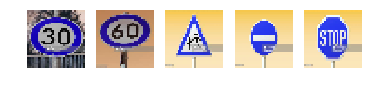

In [180]:
# Plot the "good" images

print('"Good" images:')
plot_images_in_row(n_good_images,img_array_good)

"Bad" images:


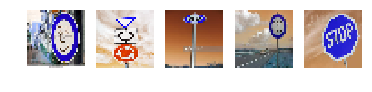

In [181]:
# Plot the "bad" images
print('"Bad" images:')
plot_images_in_row(n_bad_images,img_array_bad)

In [182]:
# Pre-process and augment the images

preprocess_good_img_array = preprocess_images(img_array_good)
preprocess_bad_img_array = preprocess_images(img_array_bad)

augment_imgs(preprocess_good_img_array)
augment_imgs(preprocess_bad_img_array)

In [183]:
%matplotlib inline
def plot_images(num,imgs,title):
    for i in range(num):
        image = imgs[i].squeeze()
        fig = plt.figure(figsize=(1,1))
        fig_title = title+" {:d} ".format(i+1)
        plt.title(fig_title)
        plt.imshow(image, cmap="gray")
        plt.axis("off")

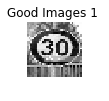

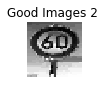

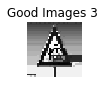

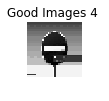

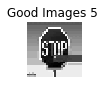

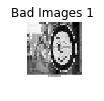

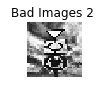

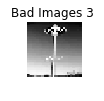

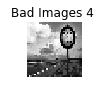

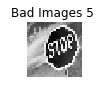

In [184]:
# Plot the "good" images after preprocess

plot_images(n_good_images,preprocess_good_img_array,"Good Images")
plot_images(n_bad_images,preprocess_bad_img_array,"Bad Images")


In [203]:
def predicts(imgs):
    with tf.Session() as sess:
        saver.restore(sess, tf.train.latest_checkpoint('.'))
        probabilities =sess.run(tf.nn.softmax(logits),feed_dict={x: imgs})
    return probabilities

In [204]:
def find_best(num,probabilities,correct,title):
    best = []
    for prob in probabilities:
        best.append(np.argmax(prob))
    print(title)
    print()
    for i in range(num):
        print("predicted traffic sign {}: ".format(best[i])+sign_names[best[i]])
        print("correct traffic sign {}: ".format(correct[i])+sign_names[correct[i]])
        print('#####################')
        print()
    return best

In [205]:
# Run the predictions

good_correct = [1,3,28,17,14]
bad_correct = [15,13,2,0,14]
good_prob = predicts(preprocess_good_img_array)
bad_prob = predicts(preprocess_bad_img_array)
good_best = find_best(n_good_images,good_prob,good_correct,"Good images predictions")
bad_best = find_best(n_bad_images,bad_prob,bad_correct,"Bad images predictions")



Good images predictions

predicted traffic sign 1: Speed limit (30km/h)
correct traffic sign 1: Speed limit (30km/h)
#####################

predicted traffic sign 17: No entry
correct traffic sign 3: Speed limit (60km/h)
#####################

predicted traffic sign 25: Road work
correct traffic sign 28: Children crossing
#####################

predicted traffic sign 17: No entry
correct traffic sign 17: No entry
#####################

predicted traffic sign 35: Ahead only
correct traffic sign 14: Stop
#####################

Bad images predictions

predicted traffic sign 40: Roundabout mandatory
correct traffic sign 15: No vehicles
#####################

predicted traffic sign 34: Turn left ahead
correct traffic sign 13: Yield
#####################

predicted traffic sign 18: General caution
correct traffic sign 2: Speed limit (50km/h)
#####################

predicted traffic sign 25: Road work
correct traffic sign 0: Speed limit (20km/h)
#####################

predicted traffic sign 1

### Analyze Performance

In [206]:
def analyze_performance_imgs(num,imgs,best,correct):
    correct_counter =0

    for i in range(num):
        if correct[i]==best[i]:
            correct_counter+=1
    
    print("Images Test Accuracy = {:.0f}%".format((correct_counter*100)/num))

In [207]:
### Calculate the accuracy:

print("Good Images:")
analyze_performance_imgs(n_good_images,preprocess_good_img_array,good_best,good_correct)

print("Bad Images:")
analyze_performance_imgs(n_bad_images,preprocess_bad_img_array,bad_best,bad_correct)

Good Images:
Images Test Accuracy = 40%
Bad Images:
Images Test Accuracy = 20%


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

In [208]:
def print_top_prob(probs,title):
    with tf.Session() as sess:
        saver.restore(sess, tf.train.latest_checkpoint('.'))
        print(title)
        top = sess.run(tf.nn.top_k(tf.constant(probs), k=5))
        print(top)
        return top

In [211]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web.
top_good = print_top_prob(good_prob,"Top Probabilities for the Good images")
top_bad = print_top_prob(bad_prob,"Top Probabilities for the Bad images")

Top Probabilities for the Good images
TopKV2(values=array([[  9.46286023e-01,   4.31322344e-02,   9.48947854e-03,
          5.28352393e-04,   2.92180979e-04],
       [  4.64075834e-01,   3.89047056e-01,   1.23261914e-01,
          1.23614827e-02,   2.90181837e-03],
       [  9.51938093e-01,   1.95210762e-02,   1.54149933e-02,
          3.93503113e-03,   2.10240809e-03],
       [  9.64595437e-01,   3.05463057e-02,   1.68669946e-03,
          7.76867208e-04,   6.04190747e-04],
       [  6.28819942e-01,   1.56279474e-01,   1.52118713e-01,
          3.45402770e-02,   8.92522931e-03]], dtype=float32), indices=array([[ 1,  2,  5,  0,  7],
       [17,  9, 23, 34, 28],
       [25, 30, 29, 31, 23],
       [17,  9, 14, 38, 13],
       [35, 34, 38, 14, 13]], dtype=int32))
Top Probabilities for the Bad images
TopKV2(values=array([[ 0.70204479,  0.16682553,  0.03872393,  0.03026387,  0.02834346],
       [ 0.76395404,  0.21986501,  0.00703366,  0.00405126,  0.00226338],
       [ 0.61151266,  0.09826

In [232]:
def show_bar_chart_of_image(i,top,color_c):
 
    # The data of the chart
    y_plot = top[0][i]
    x_plot = top[1][i]

    # Constants of the chart

    width = 1/1.5

    fig = plt.figure()
    ax = fig.add_subplot(111)

    # The bars of the chart
    chart_image = ax.bar(x_plot, y_plot, width, color=color_c)
    
    ax.set_ylabel('Probabilities', fontsize=16)
    ax.set_xlabel('Traffic Signs Id', fontsize=16)
    ax.set_title('The Probabilities of the {:d} image:'.format(i+1), fontsize=18)
    ax.set_xticks(x_plot)

    plt.show()


Probabilities of the Good images:



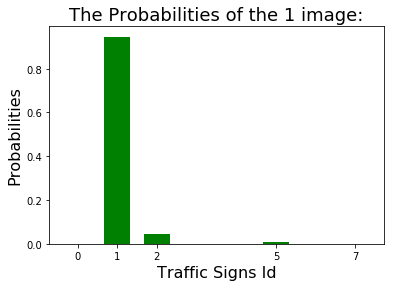

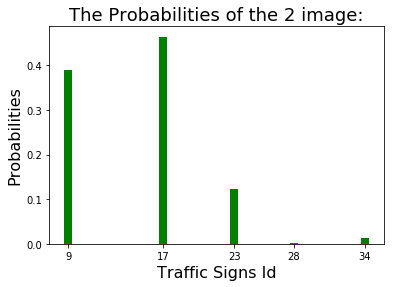

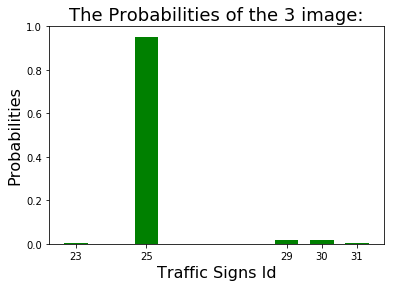

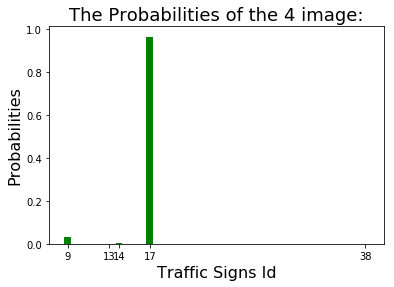

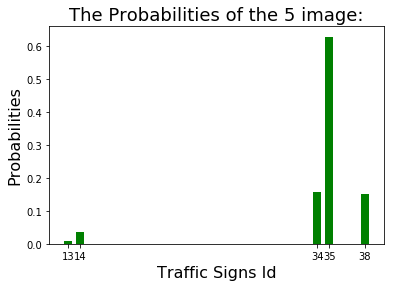

In [233]:
print("Probabilities of the Good images:")
print()

for i in range(n_good_images):
    show_bar_chart_of_image(i,top_good,"g")

Probabilities of the Bad images:



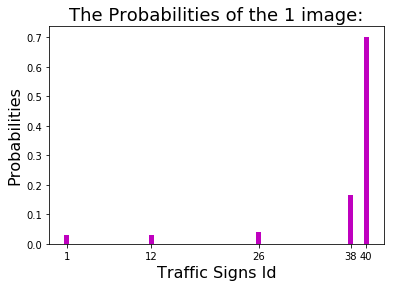

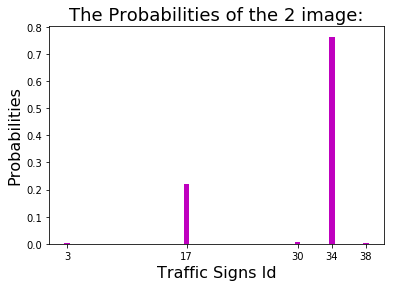

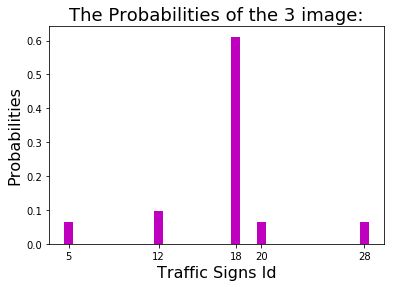

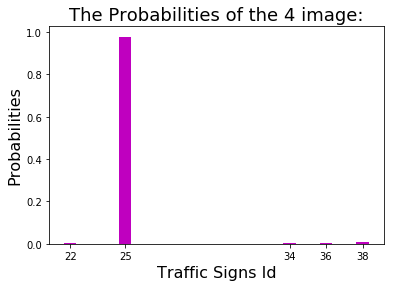

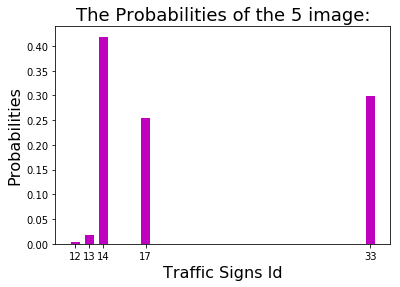

In [234]:
print("Probabilities of the Bad images:")
print()

for i in range(n_bad_images):
    show_bar_chart_of_image(i,top_bad,"m")

---

## Step 4: Visualize the Neural Network's State with Test Images

In [148]:
def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=2):
    sess = tf.get_default_session()
    
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

Layer 2 after dropout:



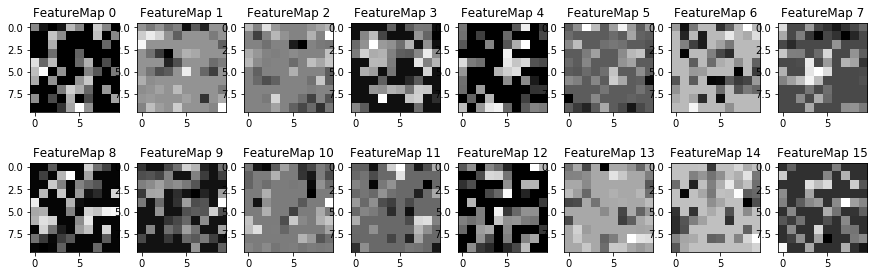

In [149]:
# Acivation of the outputFeatureMap:

image = tf.cast(X_train[0], tf.float32)
image = tf.reshape(image, [-1, 32, 32, 1])
MyNet(image)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(conv2_dropout)
    print("Layer 2 after dropout:")
    print()
    outputFeatureMap(image.eval(), conv2_dropout)

### Discussion

I used the visual output of my trained network's feature maps to show that it had learned to look for interesting characteristics in traffic sign images, like lines - a sequence of pixels which is in a different color from their background.